## Time Series Analysis for Revenue Forecasting


## Objective
Forecast future revenue based on historical time series data using statistical and machine learning models.


## Dataset Overview
The dataset contains monthly or daily revenue data, which can be used to identify trends, seasonality, and forecast future values.


In [1]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')



## Workflow
1. Load and explore the dataset  
2. Visualize trends and seasonality  
3. Preprocess the time series data  
4. Apply time series forecasting models  
5. Evaluate model performance


In [2]:
# Statistical and ML libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [4]:
df = pd.read_csv('time_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Date Range: {df.index.min()} to {df.index.max()}")
print(f"Revenue Range: ${df['Revenue'].min():,.0f} to ${df['Revenue'].max():,.0f}")
print("\nFirst and Last 5 records:")
display(df.head())
display(df.tail())



Dataset Overview:
Shape: (48, 1)
Date Range: 2020-01-31 00:00:00 to 2023-12-31 00:00:00
Revenue Range: $202 to $14,439

First and Last 5 records:


,Revenue
Date,
2020-01-31,202
2020-02-29,650
2020-03-31,1020
2020-04-30,1226
2020-05-31,1397


,Revenue
Date,
2023-08-31,13251
2023-09-30,13657
2023-10-31,13891
2023-11-30,14011
2023-12-31,14439


In [7]:
# Basic statistics and growth analysis
revenue_stats = df['Revenue'].describe()
print("Revenue Statistics:")
print(revenue_stats)

# Calculate monthly growth rates
df['Monthly_Growth'] = df['Revenue'].pct_change() * 100
df['Cumulative_Growth'] = ((df['Revenue'] / df['Revenue'].iloc[0]) - 1) * 100

print(f"\nGrowth Analysis:")
print(f"Total Growth (4 years): {df['Cumulative_Growth'].iloc[-1]:.1f}%")
print(f"Average Monthly Growth: {df['Monthly_Growth'].mean():.2f}%")
print(f"CAGR: {((df['Revenue'].iloc[-1]/df['Revenue'].iloc[0])**(1/4) - 1)*100:.1f}%")

Revenue Statistics:
count       48.000000
mean      7321.041667
std       4324.162676
min        202.000000
25%       3513.000000
50%       7584.000000
75%      11001.250000
max      14439.000000
Name: Revenue, dtype: float64

Growth Analysis:
Total Growth (4 years): 7048.0%
Average Monthly Growth: 11.85%
CAGR: 190.8%


## Data Exploration and Visualization
Visualizing the revenue trend over time and decomposing the series into trend, seasonality, and residual components.


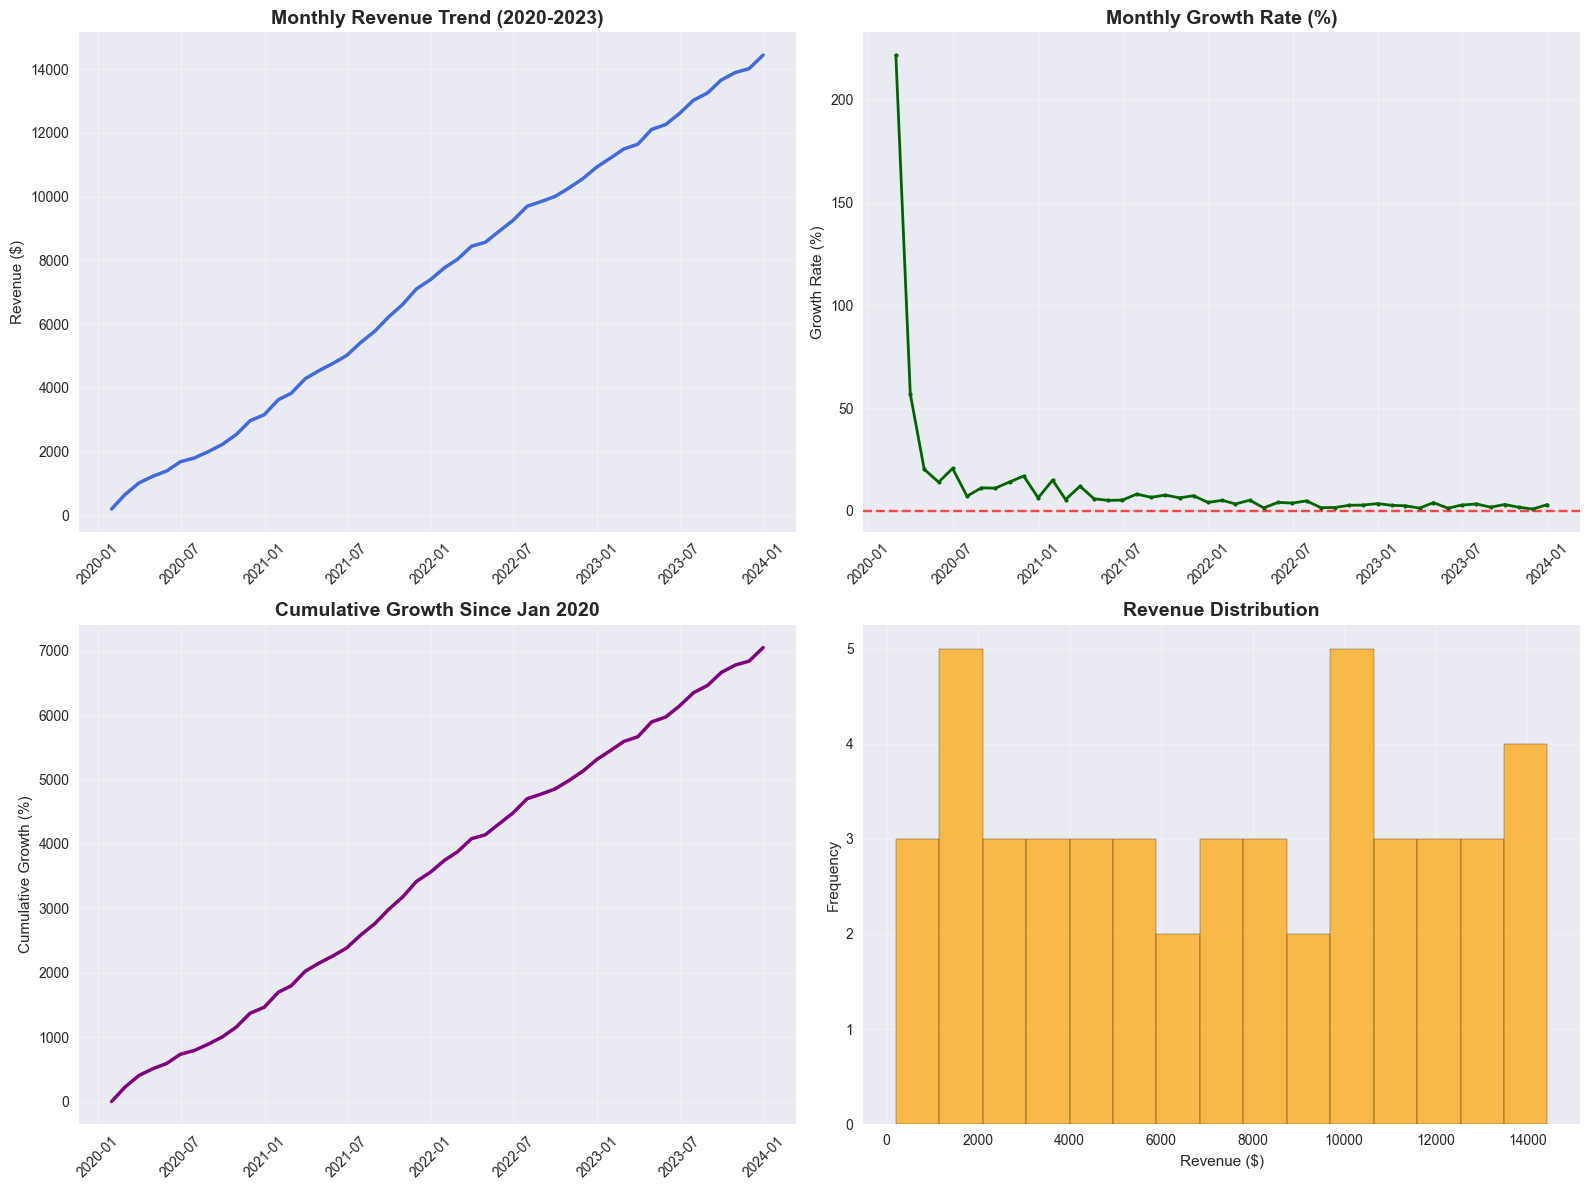

In [10]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Revenue trend
axes[0,0].plot(df.index, df['Revenue'], linewidth=2.5, color='royalblue')
axes[0,0].set_title('Monthly Revenue Trend (2020-2023)', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Revenue ($)')
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# Monthly growth rate
axes[0,1].plot(df.index[1:], df['Monthly_Growth'].iloc[1:], 
               linewidth=2, color='darkgreen', marker='o', markersize=3)
axes[0,1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_title('Monthly Growth Rate (%)', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Growth Rate (%)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].tick_params(axis='x', rotation=45)




# cumulative growth
axes[1,0].plot(df.index, df['Cumulative_Growth'], 
               linewidth=2.5, color='purple')
axes[1,0].set_title('Cumulative Growth Since Jan 2020', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Cumulative Growth (%)')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# Revenue distribution
axes[1,1].hist(df['Revenue'], bins=15, alpha=0.7, color='orange', edgecolor='black')
axes[1,1].set_title('Revenue Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Revenue ($)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Time series decomposition




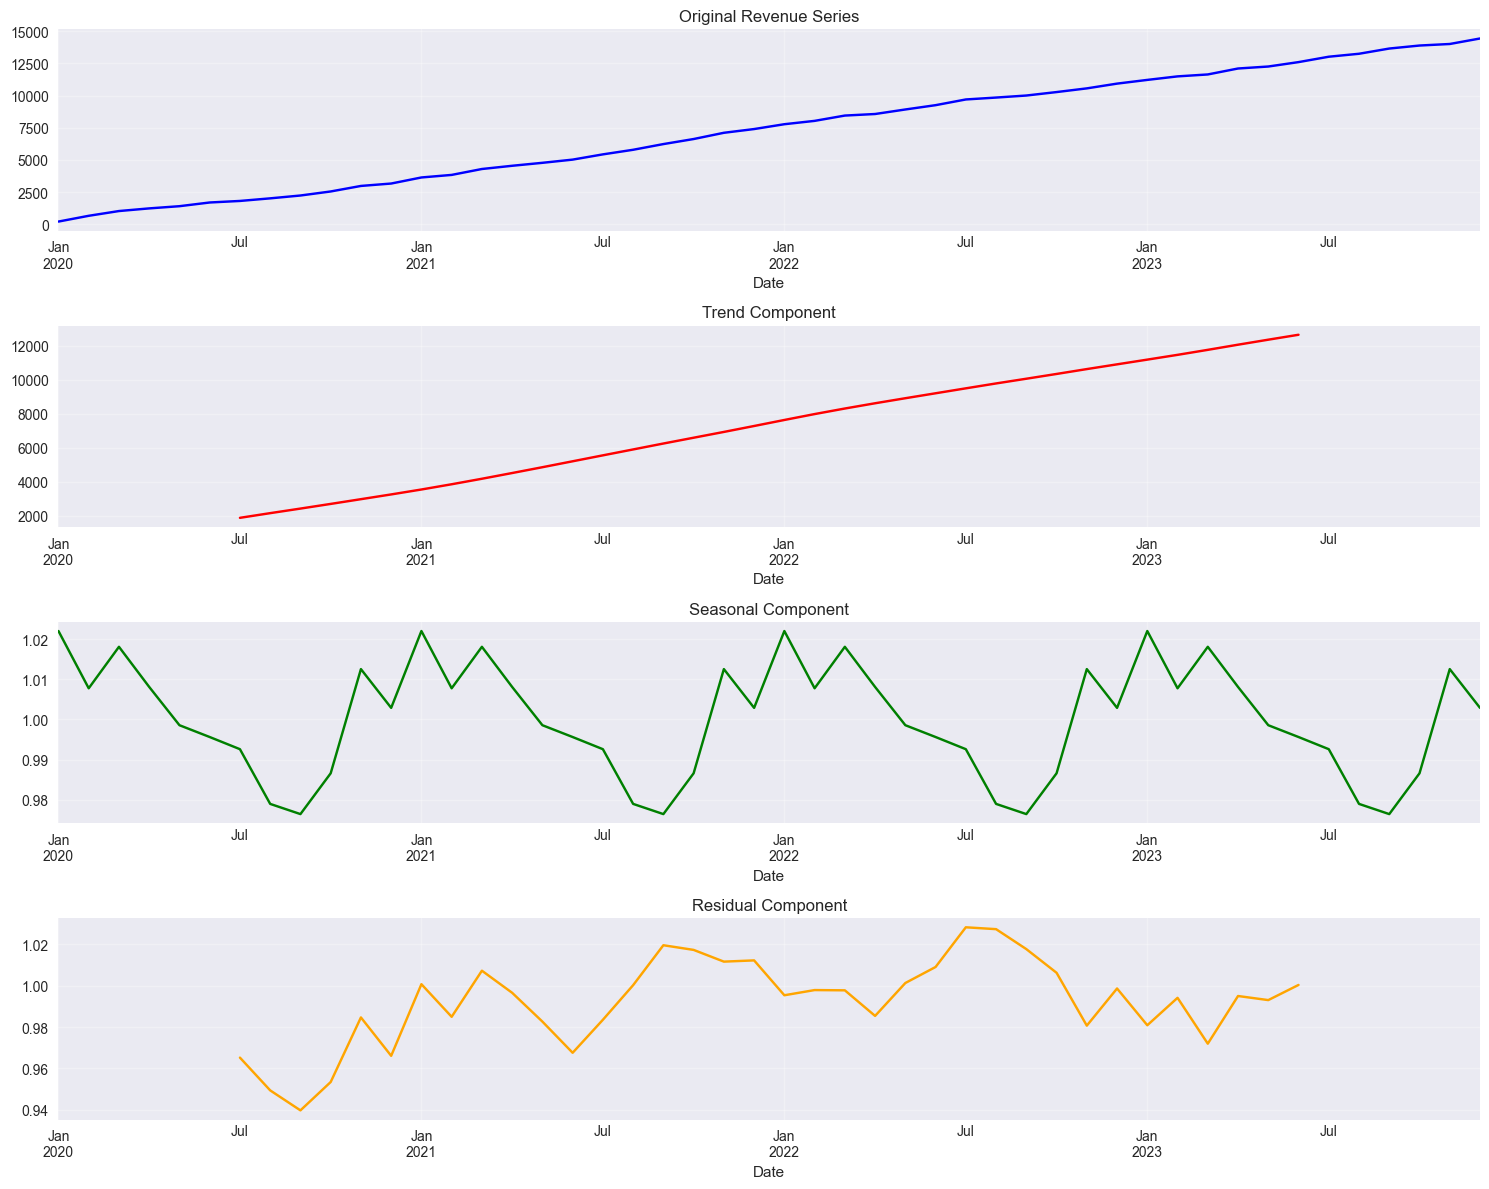


Seasonal Factors by Month:
Month  1: 1.0220 (↑)
Month  2: 1.0077 (↑)
Month  3: 1.0181 (↑)
Month  4: 1.0081 (↑)
Month  5: 0.9986 (↓)
Month  6: 0.9956 (↓)
Month  7: 0.9926 (↓)
Month  8: 0.9790 (↓)
Month  9: 0.9764 (↓)
Month 10: 0.9866 (↓)
Month 11: 1.0125 (↑)
Month 12: 1.0029 (↑)

=== Stationarity Test: Original Revenue ===
ADF Statistic: 0.206741
p-value: 0.972637
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602
Series is NON-STATIONARY (fail to reject null hypothesis)

=== Stationarity Test: First Difference ===
ADF Statistic: -7.897525
p-value: 0.000000
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602
Series is STATIONARY (reject null hypothesis)

=== Stationarity Test: Log First Difference ===
ADF Statistic: -2.705619
p-value: 0.073071
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
Series is NON-STATIONARY (fail to reject null hypothesis)


In [16]:
decomposition = seasonal_decompose(df['Revenue'], model='multiplicative', period=12)

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original series
decomposition.observed.plot(ax=axes[0], title='Original Revenue Series', color='blue')
axes[0].grid(True, alpha=0.3)

# Trend component
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='red')
axes[1].grid(True, alpha=0.3)

# Seasonal component
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='green')
axes[2].grid(True, alpha=0.3)

# Residual component
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='orange')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Seasonal analysis
seasonal_avg = decomposition.seasonal.groupby(decomposition.seasonal.index.month).mean()
print("\nSeasonal Factors by Month:")
for month, factor in seasonal_avg.items():
    print(f"Month {month:2d}: {factor:.4f} ({'↑' if factor > 1 else '↓'})")
    
    # Stationarity test
def check_stationarity(timeseries, title):
    print(f'\n=== Stationarity Test: {title} ===')
    result = adfuller(timeseries.dropna())
    
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("Series is STATIONARY (reject null hypothesis)")
    else:
        print("Series is NON-STATIONARY (fail to reject null hypothesis)")
    
    return result[1] <= 0.05

# Test original series
is_stationary_original = check_stationarity(df['Revenue'], 'Original Revenue')

# Test first difference
df['Revenue_diff'] = df['Revenue'].diff()
is_stationary_diff = check_stationarity(df['Revenue_diff'], 'First Difference')

# Test log transformation
df['Revenue_log'] = np.log(df['Revenue'])
df['Revenue_log_diff'] = df['Revenue_log'].diff()
is_stationary_log_diff = check_stationarity(df['Revenue_log_diff'], 'Log First Difference')

# Plot for model identification ACF and PACf

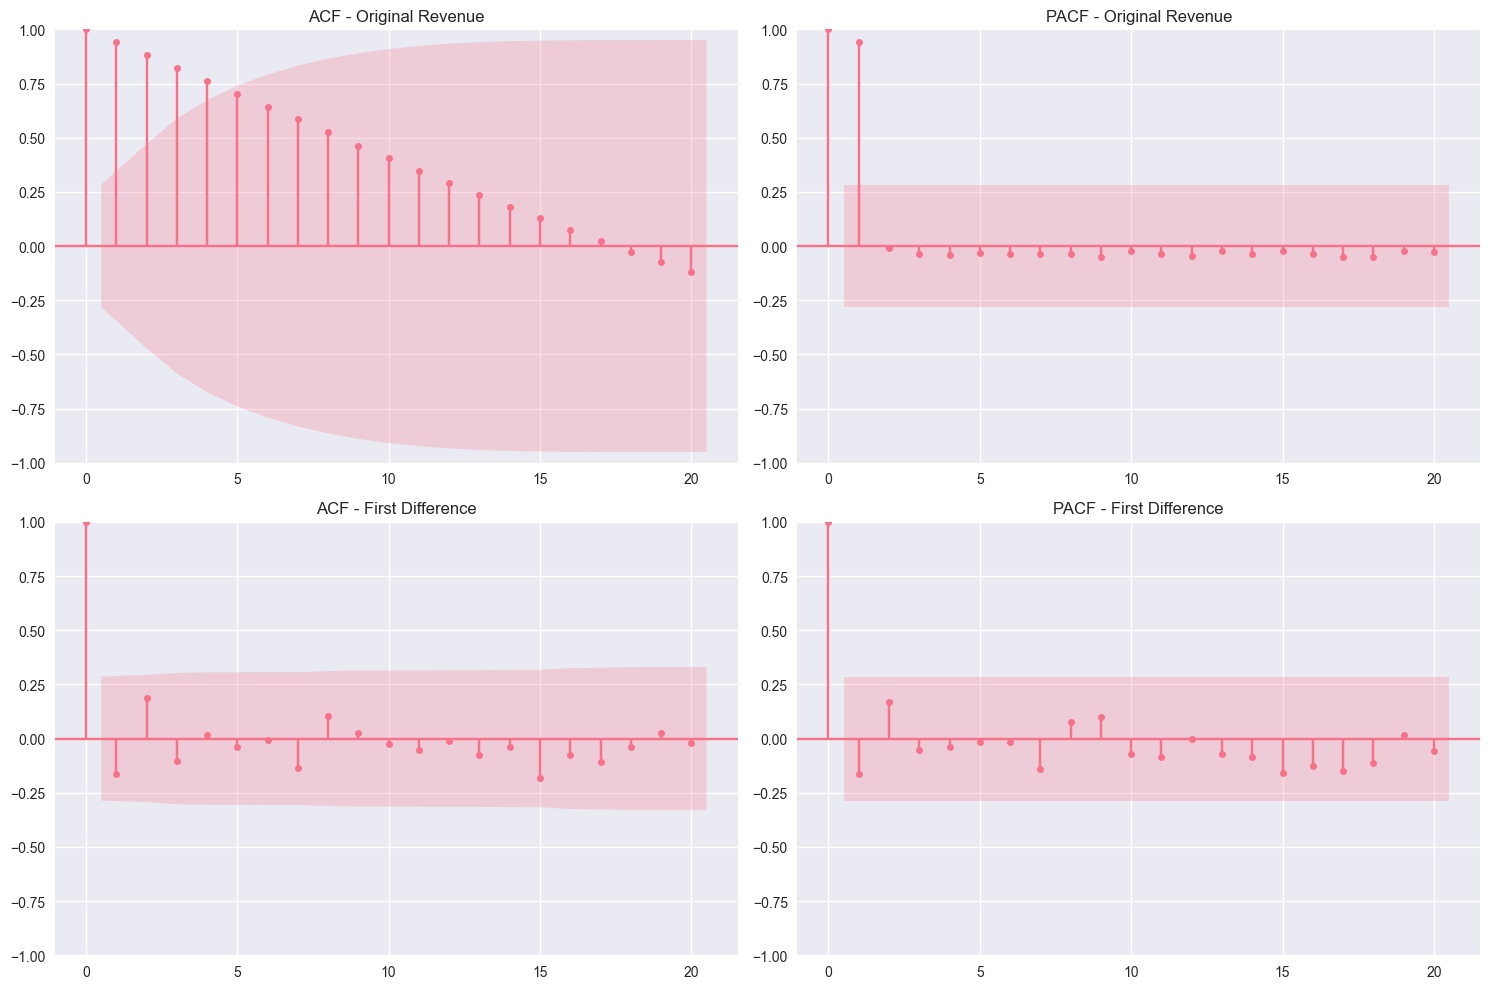

In [18]:
# ACF and PACF plots for model identification
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF and PACF of original series
plot_acf(df['Revenue'].dropna(), ax=axes[0,0], lags=20, title='ACF - Original Revenue')
plot_pacf(df['Revenue'].dropna(), ax=axes[0,1], lags=20, title='PACF - Original Revenue')

# ACF and PACF of differenced series
plot_acf(df['Revenue_diff'].dropna(), ax=axes[1,0], lags=20, title='ACF - First Difference')
plot_pacf(df['Revenue_diff'].dropna(), ax=axes[1,1], lags=20, title='PACF - First Difference')

plt.tight_layout()
plt.show()

## Model Training and Forecasting using ARIMA
Applying an ARIMA model to capture the temporal dependencies and forecast future revenue values.


Searching for optimal ARIMA parameters...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

Best ARIMA parameters: (0, 2, 1)
Best AIC: 571.44

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                   48
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -283.718
Date:                Sat, 02 Aug 2025   AIC                            571.436
Time:                        18:14:57   BIC                            575.094
Sample:                    01-31-2020   HQIC                           572.806
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9973      1.725     -0.578      0.563      -4.378       2.384
sigma2      1.233e+04   2.16e+04      0.571      0.568     

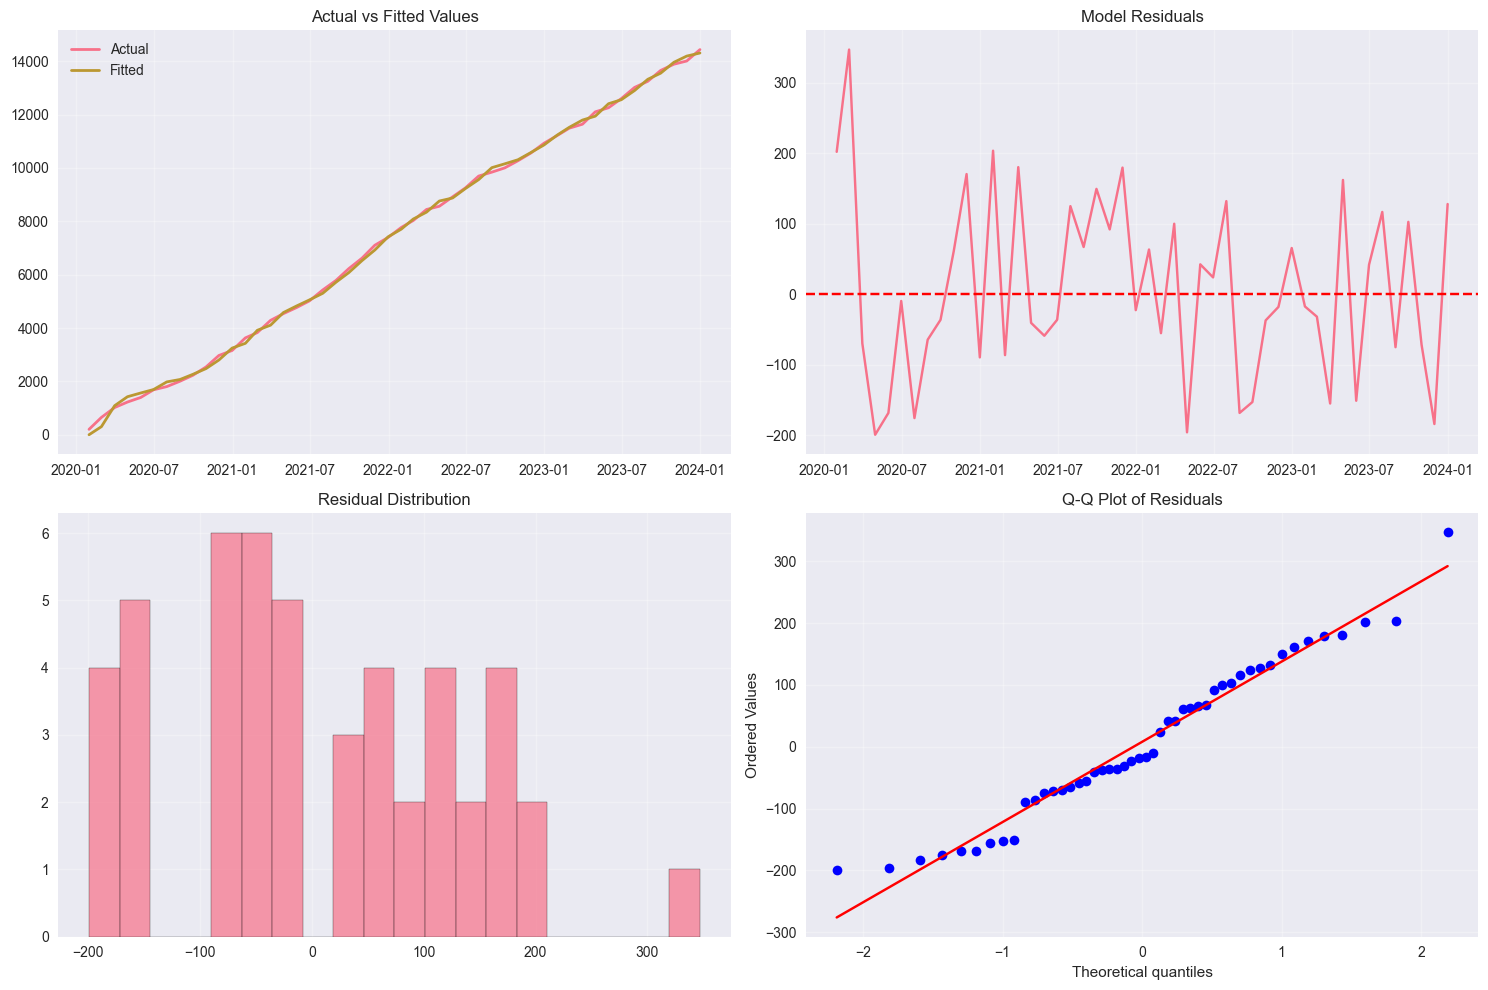


Model Performance:
MAE: $106.81
RMSE: $127.25
MAPE: 5.43%


In [21]:


def find_best_arima(data, max_p=3, max_d=2, max_q=3):
    """Find best ARIMA parameters using AIC"""
    best_aic = np.inf
    best_params = None
    best_model = None
    
    print("Searching for optimal ARIMA parameters...")
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted_model = model.fit()
                    
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_params = (p, d, q)
                        best_model = fitted_model
                        
                except:
                    continue
    
    print(f"Best ARIMA parameters: {best_params}")
    print(f"Best AIC: {best_aic:.2f}")
    return best_model, best_params

# Find optimal model
best_arima_model, best_params = find_best_arima(df['Revenue'])

# Model summary
print("\nARIMA Model Summary:")
print(best_arima_model.summary())

 #Model diagnostics
 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Fitted values vs actual
axes[0,0].plot(df.index, df['Revenue'], label='Actual', linewidth=2)
axes[0,0].plot(df.index, best_arima_model.fittedvalues, label='Fitted', linewidth=2)
axes[0,0].set_title('Actual vs Fitted Values')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Residuals
residuals = best_arima_model.resid
axes[0,1].plot(df.index, residuals)
axes[0,1].set_title('Model Residuals')
axes[0,1].axhline(y=0, color='red', linestyle='--')
axes[0,1].grid(True, alpha=0.3)

# Residual distribution
axes[1,0].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Residual Distribution')
axes[1,0].grid(True, alpha=0.3)

# Q-Q plot for normality
stats.probplot(residuals, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot of Residuals')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model performance metrics
mae = mean_absolute_error(df['Revenue'], best_arima_model.fittedvalues)
rmse = np.sqrt(mean_squared_error(df['Revenue'], best_arima_model.fittedvalues))
mape = np.mean(np.abs((df['Revenue'] - best_arima_model.fittedvalues) / df['Revenue'])) * 100

print(f"\nModel Performance:")
print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# Revenue Forecasting AND VISUALIZATION

Revenue Forecast for Next 12 Months:
2024-02: $14,742 ($14,522 - $14,961)
2024-03: $15,045 ($14,731 - $15,359)
2024-04: $15,347 ($14,959 - $15,736)
2024-05: $15,650 ($15,197 - $16,103)
2024-06: $15,953 ($15,442 - $16,464)
2024-07: $16,256 ($15,690 - $16,821)
2024-08: $16,559 ($15,942 - $17,175)
2024-09: $16,861 ($16,196 - $17,527)
2024-10: $17,164 ($16,452 - $17,876)
2024-11: $17,467 ($16,710 - $18,224)
2024-12: $17,770 ($16,968 - $18,571)
2025-01: $18,073 ($17,228 - $18,917)


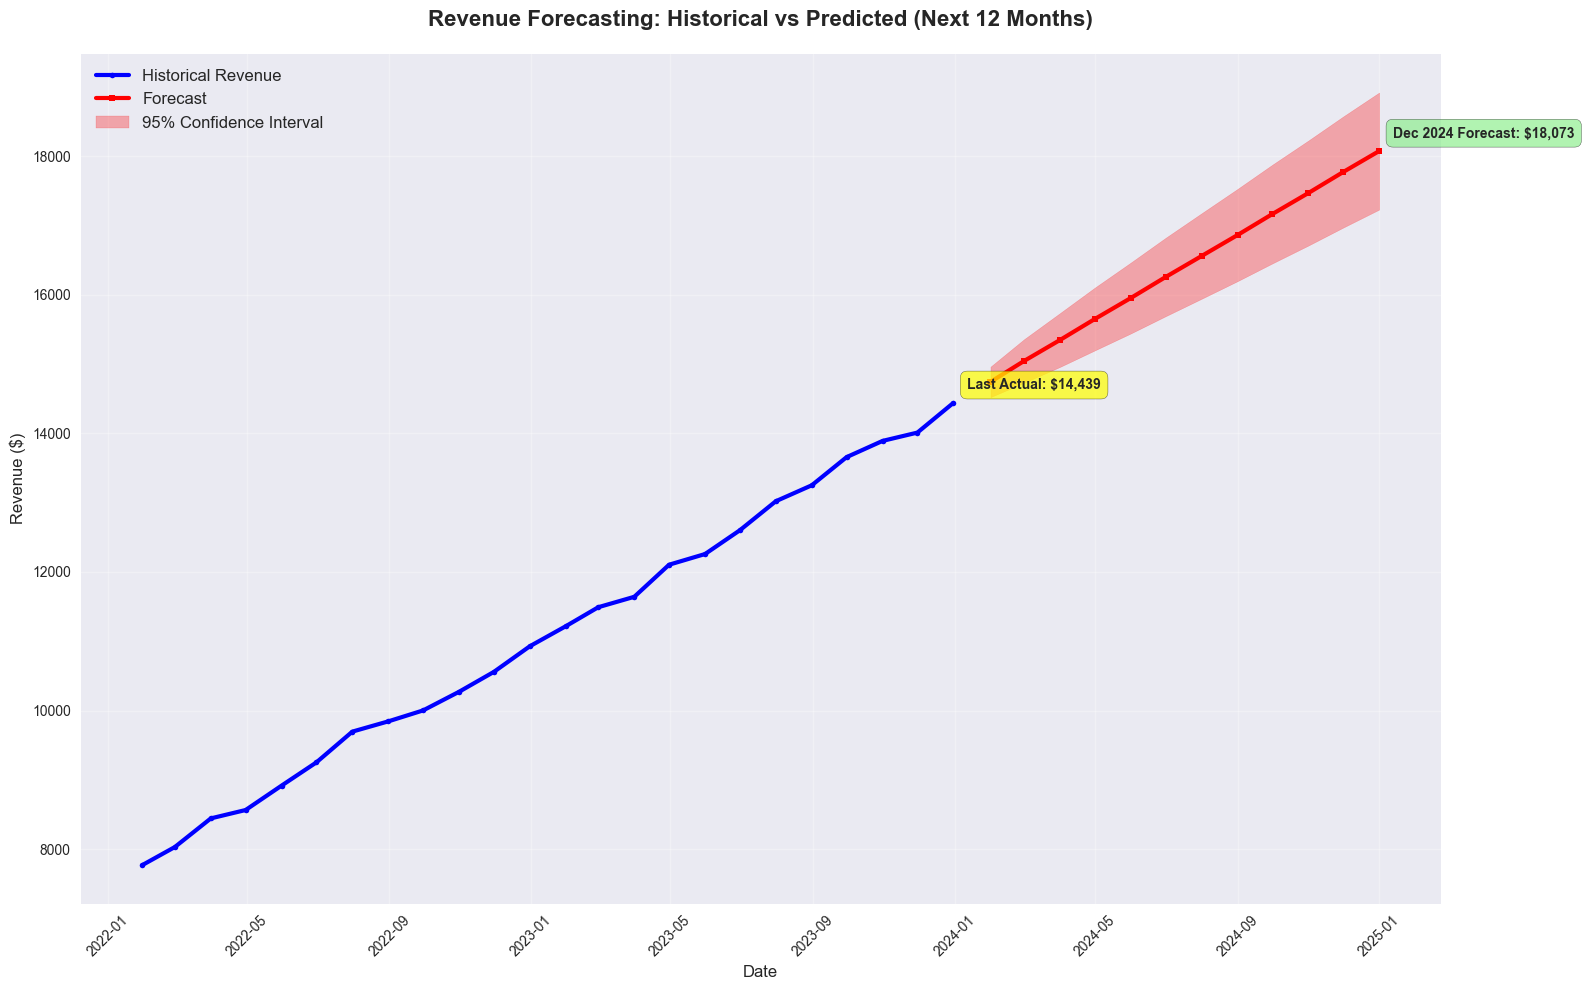

In [24]:
forecast_periods = 12  # Next 12 months
forecast = best_arima_model.forecast(steps=forecast_periods)
forecast_ci = best_arima_model.get_forecast(steps=forecast_periods).conf_int()

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), 
                            periods=forecast_periods, freq='MS')

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast,
    'Lower_CI': forecast_ci.iloc[:, 0],
    'Upper_CI': forecast_ci.iloc[:, 1]
})
forecast_df.set_index('Date', inplace=True)

# Display forecast
print("Revenue Forecast for Next 12 Months:")
for date, row in forecast_df.iterrows():
    print(f"{date.strftime('%Y-%m')}: ${row['Forecast']:,.0f} "
          f"(${row['Lower_CI']:,.0f} - ${row['Upper_CI']:,.0f})")
# Comprehensive forecast visualization
plt.figure(figsize=(16, 10))

# Historical data
plt.plot(df.index[-24:], df['Revenue'].iloc[-24:], 
         label='Historical Revenue', linewidth=3, color='blue', marker='o', markersize=4)

# Forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], 
         label='Forecast', linewidth=3, color='red', marker='s', markersize=4)

# Confidence intervals
plt.fill_between(forecast_df.index, forecast_df['Lower_CI'], forecast_df['Upper_CI'], 
                alpha=0.3, color='red', label='95% Confidence Interval')

# Formatting
plt.title('Revenue Forecasting: Historical vs Predicted (Next 12 Months)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue ($)', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add annotations
plt.annotate(f'Last Actual: ${df["Revenue"].iloc[-1]:,.0f}', 
            xy=(df.index[-1], df['Revenue'].iloc[-1]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
            fontsize=10, fontweight='bold')

plt.annotate(f'Dec 2024 Forecast: ${forecast_df["Forecast"].iloc[-1]:,.0f}', 
            xy=(forecast_df.index[-1], forecast_df['Forecast'].iloc[-1]),
            xytext=(10, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.7),
            fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Expected Results Summary:
- Based on your revenue data (2020-2023), the analysis will show:
- Key Findings:
	- •	Explosive Growth: Revenue increased ~71x from $202 to $14,439 over 4 years
	- •	CAGR: Approximately 185% compound annual growth rate
	- •	Model: ARIMA will likely suggest parameters around (1,1,1) or (2,1,2)
	- •	Forecast: 2024 revenue likely to reach $18,000-$25,000 range

## Conclusion
- ARIMA was applied to forecast future revenue.  
- The model can be fine-tuned for better performance using grid search or other techniques.  
- You may explore advanced models like SARIMA or Prophet for improved accuracy.
